In [111]:
# ---time series analysis ----
# --- this script is to analyze the time seris of OT and OTA, including trend analysis---

import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats
import glob
from pyhdf.SD import SD, SDC
import h5py
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

print('start',datetime.now())

#years=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009',\
#    '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
#years=['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',\
#       '2014','2015','2016','2017','2018','2019','2020','2021'] # for Aqua, 2002 doesn't have data for a full year
years=['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',\
       '2014','2015','2016','2017','2018','2019','2020','2021'] # for Aqua, 2002 doesn't have data for a full yea

nyear=len(years)
nmonth=len(years)*12

All_OT_num=np.zeros((360,180,nmonth,2),'f')
All_OTA = np.zeros((360,180,nmonth,2),'f')
#All_OTA_poly = np.zeros((360,180,12,2),'f')
All_OT_hetero=np.zeros((360,180,nmonth,2),'f')

yi=0

for year in years:
    fname='/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_'+year+'.h5'
    #fname='/data/keeling/a/yulanh/c/OT_climatology/MODIS_OTNOT_summary_polygon2_'+year+'.h5'
    print(fname)
    fid = h5py.File(fname,'r')
    OT_num= fid['OT_num'] 
    OTA = fid['OTA_map']
    #OTA_poly=fid['OTA_poly_map']
    OT_hetero_map=fid['OT_hetero_map']
    
    All_OT_num[:,:,yi:yi+12,:]=OT_num
    All_OTA[:,:,yi:yi+12,:]=OTA
    All_OT_hetero[:,:,yi:yi+12,:]=OT_hetero_map
    
    yi=yi+12

    



start 2022-10-05 16:51:08.980728
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2003.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2004.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2005.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2006.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2007.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2008.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2009.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2010.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2011.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2012.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2013.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_2014.h5
/data/keeling/a/yulanh/c/OT_climatology/Aqua_MODIS_OTNOT_nopolygon_

In [112]:
# upscale to 1x1 resolution to 5x5

nlatres=5
nlonres=10
nxdim=int(360/nlonres)
nydim=int(180/nlatres)
nAll_OT_num=np.zeros((nxdim,nydim,nmonth,2),'f')
nAll_OTA = np.zeros((nxdim,nydim,nmonth,2),'f')
nAll_hetero = np.zeros((nxdim,nydim,nmonth,2),'f')

for xi in range(nxdim):
    for yi in range(nydim):
        lonlow=xi*nlonres
        lonup =(xi+1)*nlonres
        latlow=yi*nlatres
        latup =(yi+1)*nlatres
        #print(All_OT_num[lonlow:lonup,latlow:latup,:,:].shape)
        tpnum=np.sum(All_OT_num[lonlow:lonup,latlow:latup,:,:],axis=0)
        tpnum=np.sum(tpnum,axis=0)
        nAll_OT_num[xi,yi,:,:]= tpnum
        tpota=np.sum(All_OTA[lonlow:lonup,latlow:latup,:,:],axis=0)
        tpota=np.sum(tpota,axis=0)
        nAll_OTA[xi,yi,:,:]=tpota
        
        tphetero=np.sum(All_OT_hetero[lonlow:lonup,latlow:latup,:,:],axis=0)
        tphetero=np.sum(tphetero,axis=0)
        nAll_hetero[xi,yi,:,:]=tphetero
        

412.0


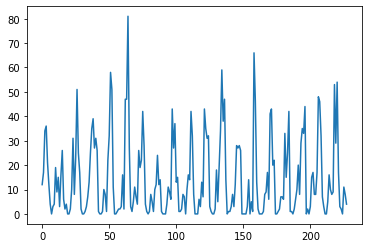

In [24]:
#-- check upscale ---
#plt.imshow(All_OT_num[:,:,10,0])
#plt.show()
#plt.imshow(nAll_OT_num[:,:,10,0])
#plt.show()
plt.plot(nAll_OT_num[18,18,:,0])
print(np.max(nAll_OT_num))

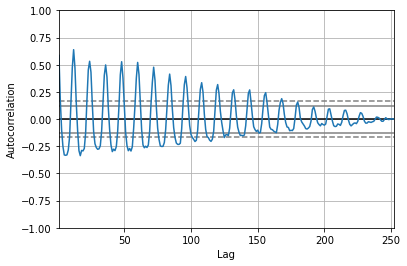

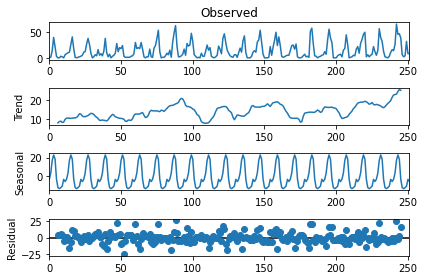

(252, 1) (252,)
-3.9229247364661886 [0.03125837] 14.039682
0.031258366484516964 -3.922924630502371 0.1493639474597499 0.01766263885361902


In [78]:
# ---trend analysis ---
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression


x=np.arange(nmonth).reshape((-1, 1))


a=nAll_OT_num[18,18,:,0]
autocorrelation_plot(a)
plt.show()

decompose=seasonal_decompose(a,model='additive',period=12)
decompose.plot()
plt.show()

anormaly=a-np.mean(a)
print(x.shape,anormaly.shape)
model = LinearRegression().fit(x, anormaly)
print(model.intercept_,model.coef_,np.mean(a))
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(nmonth),anormaly)
print(slope,intercept,r_value,p_value)

In [113]:
OT_num_trend=np.zeros((nxdim,nydim),'f')
trend_signfc=np.empty((),'i')
trend_signfc_lon=np.empty((),'f')
trend_signfc_lat=np.empty((),'f')

OTA_trend=np.zeros((nxdim,nydim),'f')

lon=np.arange(nxdim)*nlonres-180+nlonres/2.0
lat=np.arange(nydim)*nlatres-90+nlatres/2.0

for xi in range(nxdim):
    for yi in range(nydim):
      
        tpnum=nAll_OT_num[xi,yi,:,1]
        if (np.max(tpnum) > 20):
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(nmonth),tpnum)
            OT_num_trend[xi,yi]=slope
            tpOTA=nAll_OTA[xi,yi,:,1]/tpnum
            ind=np.where(tpnum ==0)[0]
            tpOTA[ind]=0.0
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(nmonth),tpOTA)
            OTA_trend[xi,yi]=slope

            if (p_value < 0.01):
                trend_signfc=np.append(trend_signfc,1)
                trend_signfc_lon=np.append(trend_signfc_lon,lon[xi])
                trend_signfc_lat=np.append(trend_signfc_lat,lat[yi])
        
        
 

/tmp/ipykernel_201137/3087046533.py:18: RuntimeWarning: invalid value encountered in true_divide
  tpOTA=nAll_OTA[xi,yi,:,1]/tpnum


[62.5] i


0.054655313 -0.12041972


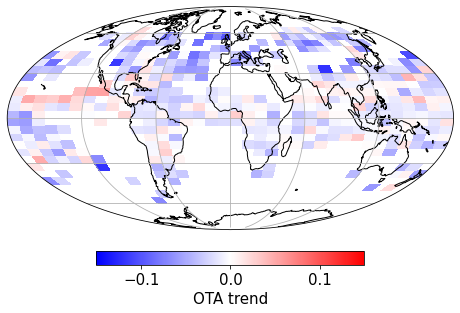

In [114]:
fig,axs =plt.subplots(1,figsize=([8,8]),subplot_kw={'projection': ccrs.Mollweide()},constrained_layout=True)
img_extent=(-180,180,-90,90)
data=OT_num_trend
data=data.T
print(np.max(data),np.min(data))
nvmin=-0.05
nvmax=0.05
#nvmin=-0.15
#nvmax=0.15

fontsz=15

#data=np.fliplr(data)
data[data ==0]='nan'
s0=axs.pcolormesh(lon,lat,data,transform=ccrs.PlateCarree(),vmin=nvmin,vmax=nvmax,cmap=plt.get_cmap('bwr'))#('Set3',4)) #('jet'))
axs.coastlines(resolution='110m', color='black', linewidth=1)
gl=axs.gridlines(draw_labels=True)
gl.xlabel_style={'size':12,'color':'black'}
gl.ylabel_style={'size':12,'color':'black'}
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.ylabels_left = False

#p0=axs.scatter(trend_signfc_lon,trend_signfc_lat,marker='+',s=1.8,\
#               transform=ccrs.PlateCarree(),color='black')

cb=plt.colorbar(s0,ax=axs,orientation='horizontal',shrink=0.6,pad=0.05)
cb.ax.tick_params(labelsize=fontsz)
#cb.set_label(label='OT number trend',size=fontsz)
cb.set_label(label='OTA trend',size=fontsz)
#cb.set_ticks([1,2,3,4])
#cb.ax.set_yticklabels(['01:30','10:30','13:30','22:30'])